In [14]:
#importing the necessary packages
import pandas as pd
import numpy as np
from PyBioMed import Pymolecule
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [15]:
def getRepresentation(smi,feature,i):
    mol = Pymolecule.PyMolecule()
    mol.ReadMolFromSmile(smi)
    res = mol.GetFingerprint(FPName=feature)
    return np.asarray(res[i]).reshape(1,1024)
    
def preProcess(filename,featureName):
    data = pd.read_csv(filename,delimiter=',',dtype='str')
    for i in range(len(data.formula)):
        try:
            if i==0:
                features = getRepresentation(data.formula[i],featureName,0)
                labels = np.array([int(data.label[i])])
            else:
                features = np.vstack((features,getRepresentation(data.formula[i],featureName,0)))
                labels = np.vstack((labels,np.array([int(data.label[i])])))
        except: #leave out those compunds for which ECFP6 features cannot be calculated
            continue
    return features,labels

In [18]:
def defineNN():
    nn = Sequential()
    nn.add(Dense(512,kernel_initializer='uniform',activation='tanh',input_dim=1024))
    nn.add(Dense(1, kernel_initializer='uniform',activation='relu'))
    nn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return nn

def accuracyForNN(predictions,trueLabels):
    predictions[np.where(predictions>=0.5)[0]]=1
    predictions[np.where(predictions<0.5)[0]]=0
    return round(accuracy_score(trueLabels,predictions.astype(int)),2)

In [4]:
def plotROC(assay,featureName):
    print('Assay: ',assay)
    features,labels = preProcess(assay,featureName)
    X_train,X_test,y_train,y_test = train_test_split(features,labels,random_state=3,test_size=0.25)

    sm = SMOTETomek()
    features,labels = sm.fit_sample(features,labels)
    XS_train,XS_test,ys_train,ys_test = train_test_split(features,labels,random_state=3,test_size=0.25)
    
    fig, (ax1,ax2) = plt.subplots(1, 2)

    model = RandomForestClassifier(n_estimators=25)
    model.fit(X_train,y_train)
    y_predict = model.predict(X_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    ax1.set_title('ROC for Random Forest w/o SMOTE')
    ax1.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    ax1.legend(loc='lower right')
    ax1.plot([0,1],[0,1],'r--')

    model = RandomForestClassifier(n_estimators=25)
    model.fit(XS_train,ys_train)
    ys_predict = model.predict(XS_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(ys_test, ys_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    ax2.set_title('ROC for Random Forest with SMOTE')
    ax2.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    ax2.legend(loc='lower right')
    ax2.plot([0,1],[0,1],'r--')
    
    plt.tight_layout()

    plt.show()

    print('Random forest Without SMOTE: ')
    print ('Accuracy ',round(accuracy_score(y_test,y_predict) * 100,2))
    print(classification_report(y_test,y_predict))

    print('Random forest With SMOTE: ')
    print ('Accuracy ',round(accuracy_score(ys_test,ys_predict) * 100,2))
    print(classification_report(ys_test,ys_predict))

    
    fig, (ax1,ax2) = plt.subplots(1, 2)

    model = svm.SVC(kernel='linear')
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    ax1.set_title('ROC for SVM w/o SMOTE')
    ax1.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    ax1.legend(loc='lower right')
    ax1.plot([0,1],[0,1],'r--')

    model = svm.SVC(kernel='linear')
    model.fit(XS_train, ys_train)
    ys_predict = model.predict(XS_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(ys_test, ys_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    ax2.set_title('ROC for SVM with SMOTE')
    ax2.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    ax2.legend(loc='lower right')
    ax2.plot([0,1],[0,1],'r--')
    
    plt.tight_layout()
    plt.show()

    print('SVM Without SMOTE: ')
    print ('Accuracy ',round(accuracy_score(y_test,y_predict) * 100,2))
    print(classification_report(y_test,y_predict))

    print('SVM With SMOTE: ')
    print ('Accuracy ',round(accuracy_score(ys_test,ys_predict) * 100,2))
    print(classification_report(ys_test,ys_predict))

    fig, (ax1,ax2) = plt.subplots(1, 2)
    model = defineNN()
    model.fit(X_train, y_train,epochs=100,batch_size=32,verbose=False)
    y_predict = model.predict(X_test)
    y_predict[np.where(y_predict>=0.5)[0]]=1
    y_predict[np.where(y_predict<0.5)[0]]=0

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    ax1.set_title('ROC for NN w/o SMOTE')
    ax1.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    ax1.legend(loc='lower right')
    ax1.plot([0,1],[0,1],'r--')

    model = defineNN()
    model.fit(XS_train, ys_train,epochs=100,batch_size=32,verbose=False)
    ys_predict = model.predict(XS_test)
    ys_predict[np.where(ys_predict>=0.5)[0]]=1
    ys_predict[np.where(ys_predict<0.5)[0]]=0

    false_positive_rate, true_positive_rate, thresholds = roc_curve(ys_test, ys_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    ax2.set_title('ROC for NN with SMOTE')
    ax2.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    ax2.legend(loc='lower right')
    ax2.plot([0,1],[0,1],'r--')
    plt.tight_layout()
    plt.show()

    print('NN Without SMOTE: ')
    print ('Accuracy ',round(accuracy_score(y_test,y_predict) * 100,2))
    print(classification_report(y_test,y_predict))

    print('NN With SMOTE: ')
    print ('Accuracy ',round(accuracy_score(ys_test,ys_predict) * 100,2))
    print(classification_report(ys_test,ys_predict))

('Assay: ', 'nrahr.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


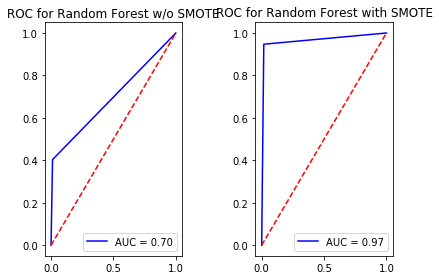

Random forest Without SMOTE: 
('Accuracy ', 91.72)
             precision    recall  f1-score   support

          0       0.92      0.99      0.95      1793
          1       0.83      0.40      0.54       248

avg / total       0.91      0.92      0.90      2041

Random forest With SMOTE: 
('Accuracy ', 96.53)
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      1825
          1       0.98      0.95      0.96      1782

avg / total       0.97      0.97      0.97      3607



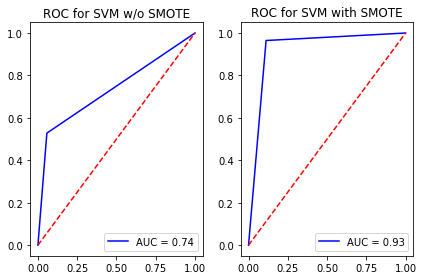

SVM Without SMOTE: 
('Accuracy ', 89.27)
             precision    recall  f1-score   support

          0       0.94      0.94      0.94      1793
          1       0.56      0.53      0.54       248

avg / total       0.89      0.89      0.89      2041

SVM With SMOTE: 
('Accuracy ', 92.6)
             precision    recall  f1-score   support

          0       0.96      0.89      0.92      1825
          1       0.89      0.96      0.93      1782

avg / total       0.93      0.93      0.93      3607



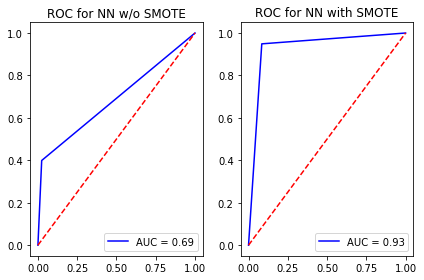

NN Without SMOTE: 
('Accuracy ', 90.59)
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      1793
          1       0.70      0.40      0.51       248

avg / total       0.89      0.91      0.89      2041

NN With SMOTE: 
('Accuracy ', 93.21)
             precision    recall  f1-score   support

          0       0.95      0.92      0.93      1825
          1       0.92      0.95      0.93      1782

avg / total       0.93      0.93      0.93      3607



In [27]:
plotROC('nrahr.csv','ECFP6')

('Assay: ', 'nrahr.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


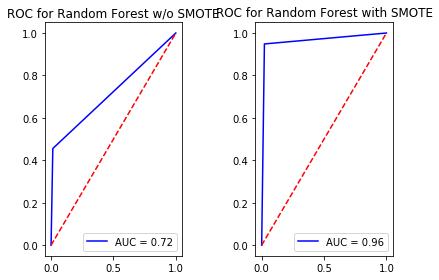

Random forest Without SMOTE: 
('Accuracy ', 92.16)
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      1793
          1       0.82      0.46      0.59       248

avg / total       0.92      0.92      0.91      2041

Random forest With SMOTE: 
('Accuracy ', 96.34)
             precision    recall  f1-score   support

          0       0.95      0.98      0.96      1821
          1       0.98      0.95      0.96      1786

avg / total       0.96      0.96      0.96      3607



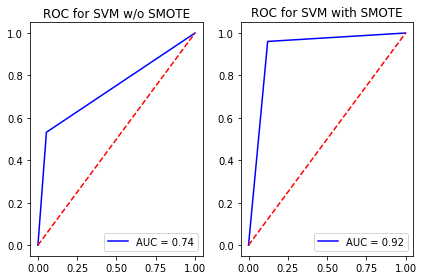

SVM Without SMOTE: 
('Accuracy ', 89.56)
             precision    recall  f1-score   support

          0       0.94      0.95      0.94      1793
          1       0.58      0.53      0.55       248

avg / total       0.89      0.90      0.89      2041

SVM With SMOTE: 
('Accuracy ', 91.88)
             precision    recall  f1-score   support

          0       0.96      0.88      0.92      1821
          1       0.89      0.96      0.92      1786

avg / total       0.92      0.92      0.92      3607



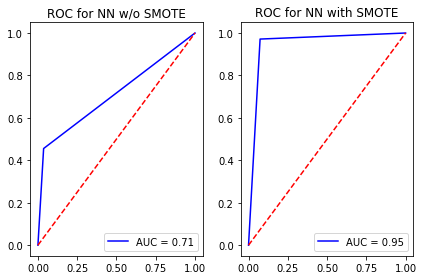

NN Without SMOTE: 
('Accuracy ', 90.2)
             precision    recall  f1-score   support

          0       0.93      0.96      0.95      1793
          1       0.63      0.46      0.53       248

avg / total       0.89      0.90      0.89      2041

NN With SMOTE: 
('Accuracy ', 94.87)
             precision    recall  f1-score   support

          0       0.97      0.93      0.95      1821
          1       0.93      0.97      0.95      1786

avg / total       0.95      0.95      0.95      3607



In [5]:
plotROC('nrahr.csv','ECFP4')

('Assay: ', 'nrar.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


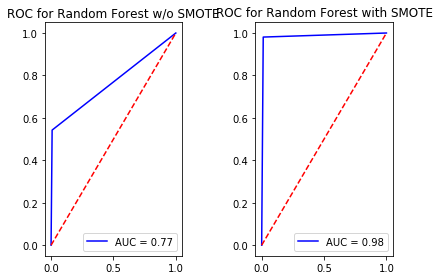

Random forest Without SMOTE: 
('Accuracy ', 97.35)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2246
          1       0.73      0.54      0.62        94

avg / total       0.97      0.97      0.97      2340

Random forest With SMOTE: 
('Accuracy ', 98.42)
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      2239
          1       0.99      0.98      0.98      2250

avg / total       0.98      0.98      0.98      4489



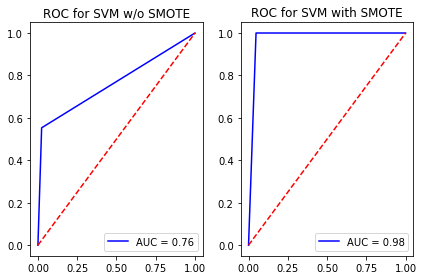

SVM Without SMOTE: 
('Accuracy ', 95.94)
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2246
          1       0.50      0.55      0.52        94

avg / total       0.96      0.96      0.96      2340

SVM With SMOTE: 
('Accuracy ', 97.62)
             precision    recall  f1-score   support

          0       1.00      0.95      0.98      2239
          1       0.95      1.00      0.98      2250

avg / total       0.98      0.98      0.98      4489



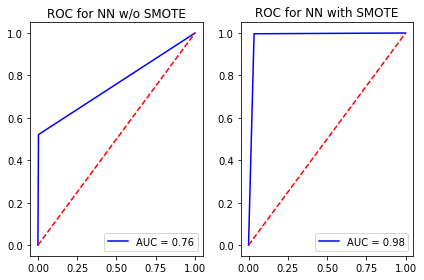

NN Without SMOTE: 
('Accuracy ', 97.74)
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2246
          1       0.86      0.52      0.65        94

avg / total       0.98      0.98      0.97      2340

NN With SMOTE: 
('Accuracy ', 98.06)
             precision    recall  f1-score   support

          0       1.00      0.96      0.98      2239
          1       0.97      1.00      0.98      2250

avg / total       0.98      0.98      0.98      4489



In [28]:
plotROC('nrar.csv','ECFP6')

('Assay: ', 'nrar.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


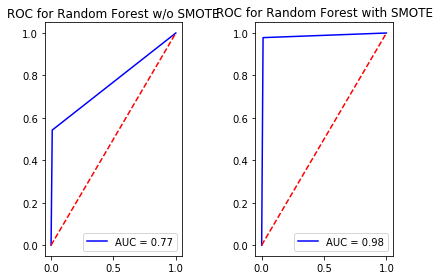

Random forest Without SMOTE: 
('Accuracy ', 97.26)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2246
          1       0.71      0.54      0.61        94

avg / total       0.97      0.97      0.97      2340

Random forest With SMOTE: 
('Accuracy ', 98.35)
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      2239
          1       0.99      0.98      0.98      2250

avg / total       0.98      0.98      0.98      4489



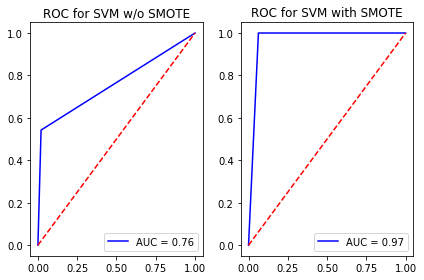

SVM Without SMOTE: 
('Accuracy ', 96.24)
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      2246
          1       0.53      0.54      0.54        94

avg / total       0.96      0.96      0.96      2340

SVM With SMOTE: 
('Accuracy ', 96.86)
             precision    recall  f1-score   support

          0       1.00      0.94      0.97      2239
          1       0.94      1.00      0.97      2250

avg / total       0.97      0.97      0.97      4489



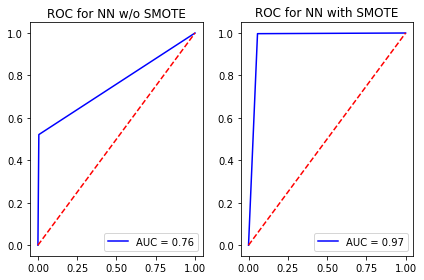

NN Without SMOTE: 
('Accuracy ', 97.52)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2246
          1       0.79      0.52      0.63        94

avg / total       0.97      0.98      0.97      2340

NN With SMOTE: 
('Accuracy ', 96.99)
             precision    recall  f1-score   support

          0       1.00      0.94      0.97      2239
          1       0.95      1.00      0.97      2250

avg / total       0.97      0.97      0.97      4489



In [6]:
plotROC('nrar.csv','ECFP4')

('Assay: ', 'nrarlbd.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


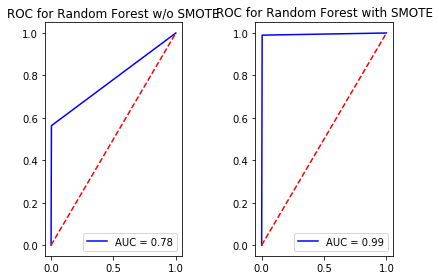

Random forest Without SMOTE: 
('Accuracy ', 98.28)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2078
          1       0.87      0.56      0.68        71

avg / total       0.98      0.98      0.98      2149

Random forest With SMOTE: 
('Accuracy ', 99.3)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2064
          1       1.00      0.99      0.99      2082

avg / total       0.99      0.99      0.99      4146



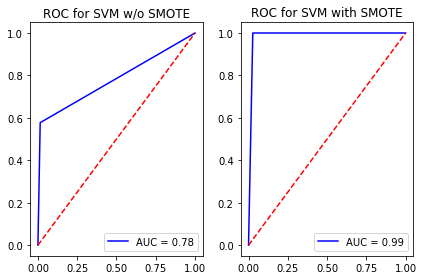

SVM Without SMOTE: 
('Accuracy ', 97.21)
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2078
          1       0.58      0.58      0.58        71

avg / total       0.97      0.97      0.97      2149

SVM With SMOTE: 
('Accuracy ', 98.65)
             precision    recall  f1-score   support

          0       1.00      0.97      0.99      2064
          1       0.97      1.00      0.99      2082

avg / total       0.99      0.99      0.99      4146



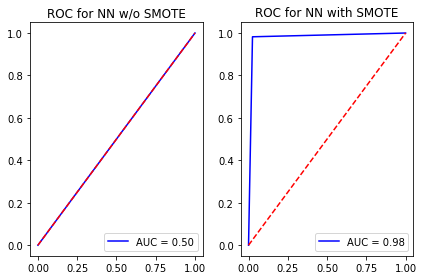

NN Without SMOTE: 
('Accuracy ', 96.7)
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      2078
          1       0.00      0.00      0.00        71

avg / total       0.94      0.97      0.95      2149

NN With SMOTE: 
('Accuracy ', 97.85)
             precision    recall  f1-score   support

          0       0.98      0.97      0.98      2064
          1       0.98      0.98      0.98      2082

avg / total       0.98      0.98      0.98      4146



/home/varshaneya/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
plotROC('nrarlbd.csv','ECFP6')

('Assay: ', 'nrarlbd.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


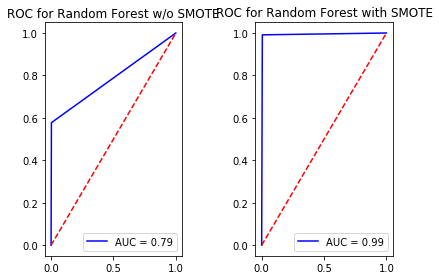

Random forest Without SMOTE: 
('Accuracy ', 98.32)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2078
          1       0.87      0.58      0.69        71

avg / total       0.98      0.98      0.98      2149

Random forest With SMOTE: 
('Accuracy ', 99.3)
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2064
          1       0.99      0.99      0.99      2082

avg / total       0.99      0.99      0.99      4146



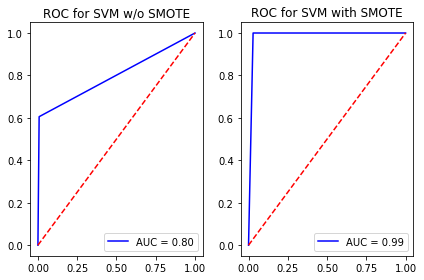

SVM Without SMOTE: 
('Accuracy ', 97.95)
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      2078
          1       0.73      0.61      0.66        71

avg / total       0.98      0.98      0.98      2149

SVM With SMOTE: 
('Accuracy ', 98.55)
             precision    recall  f1-score   support

          0       1.00      0.97      0.99      2064
          1       0.97      1.00      0.99      2082

avg / total       0.99      0.99      0.99      4146



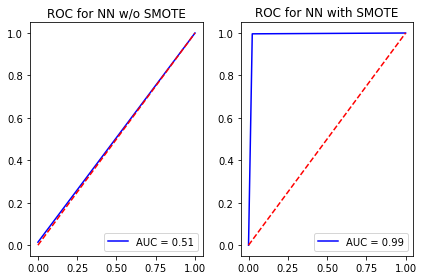

NN Without SMOTE: 
('Accuracy ', 96.74)
             precision    recall  f1-score   support

          0       0.97      1.00      0.98      2078
          1       1.00      0.01      0.03        71

avg / total       0.97      0.97      0.95      2149

NN With SMOTE: 
('Accuracy ', 98.63)
             precision    recall  f1-score   support

          0       1.00      0.98      0.99      2064
          1       0.98      1.00      0.99      2082

avg / total       0.99      0.99      0.99      4146



In [7]:
plotROC('nrarlbd.csv','ECFP4')

('Assay: ', 'nraromatase.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


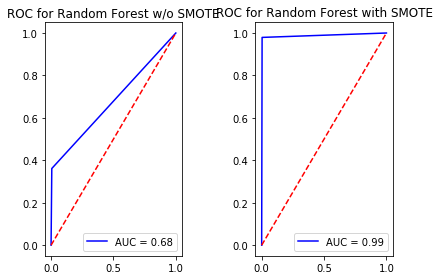

Random forest Without SMOTE: 
('Accuracy ', 96.51)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1723
          1       0.75      0.36      0.49        83

avg / total       0.96      0.97      0.96      1806

Random forest With SMOTE: 
('Accuracy ', 98.81)
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1741
          1       1.00      0.98      0.99      1690

avg / total       0.99      0.99      0.99      3431



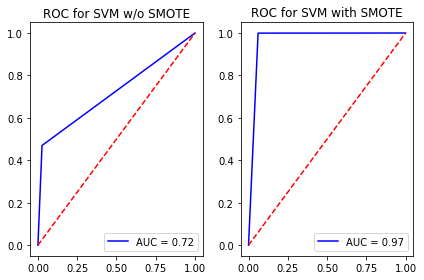

SVM Without SMOTE: 
('Accuracy ', 95.07)
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      1723
          1       0.46      0.47      0.47        83

avg / total       0.95      0.95      0.95      1806

SVM With SMOTE: 
('Accuracy ', 96.88)
             precision    recall  f1-score   support

          0       1.00      0.94      0.97      1741
          1       0.94      1.00      0.97      1690

avg / total       0.97      0.97      0.97      3431



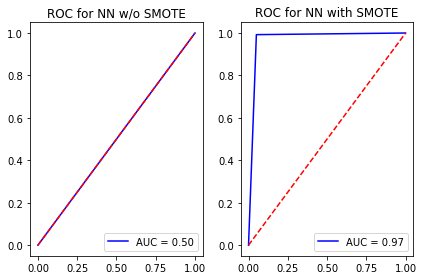

NN Without SMOTE: 
('Accuracy ', 95.4)
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      1723
          1       0.00      0.00      0.00        83

avg / total       0.91      0.95      0.93      1806

NN With SMOTE: 
('Accuracy ', 97.09)
             precision    recall  f1-score   support

          0       0.99      0.95      0.97      1741
          1       0.95      0.99      0.97      1690

avg / total       0.97      0.97      0.97      3431



In [30]:
plotROC('nraromatase.csv','ECFP6')

('Assay: ', 'nraromatase.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


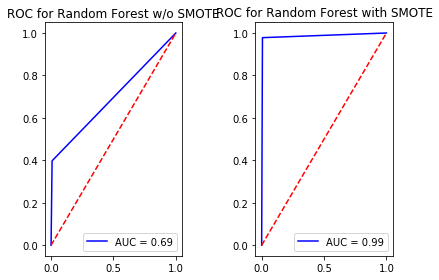

Random forest Without SMOTE: 
('Accuracy ', 96.46)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1723
          1       0.70      0.40      0.51        83

avg / total       0.96      0.96      0.96      1806

Random forest With SMOTE: 
('Accuracy ', 98.6)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1741
          1       0.99      0.98      0.99      1690

avg / total       0.99      0.99      0.99      3431



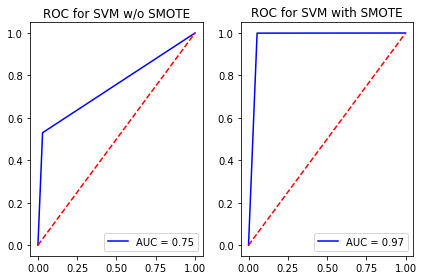

SVM Without SMOTE: 
('Accuracy ', 95.02)
             precision    recall  f1-score   support

          0       0.98      0.97      0.97      1723
          1       0.46      0.53      0.49        83

avg / total       0.95      0.95      0.95      1806

SVM With SMOTE: 
('Accuracy ', 97.2)
             precision    recall  f1-score   support

          0       1.00      0.95      0.97      1741
          1       0.95      1.00      0.97      1690

avg / total       0.97      0.97      0.97      3431



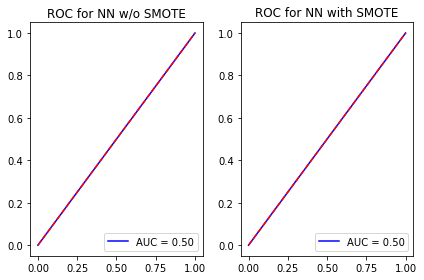

NN Without SMOTE: 
('Accuracy ', 95.4)
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      1723
          1       0.00      0.00      0.00        83

avg / total       0.91      0.95      0.93      1806

NN With SMOTE: 
('Accuracy ', 50.74)
             precision    recall  f1-score   support

          0       0.51      1.00      0.67      1741
          1       0.00      0.00      0.00      1690

avg / total       0.26      0.51      0.34      3431



/home/varshaneya/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
plotROC('nraromatase.csv','ECFP4')

('Assay: ', 'nrer.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


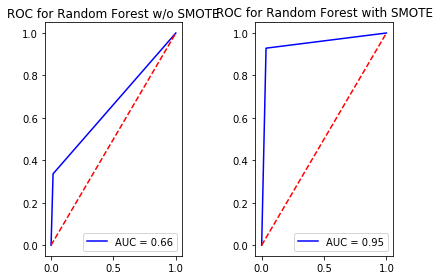

Random forest Without SMOTE: 
('Accuracy ', 90.8)
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      1698
          1       0.74      0.34      0.46       226

avg / total       0.90      0.91      0.89      1924

Random forest With SMOTE: 
('Accuracy ', 94.7)
             precision    recall  f1-score   support

          0       0.93      0.96      0.95      1712
          1       0.96      0.93      0.95      1666

avg / total       0.95      0.95      0.95      3378



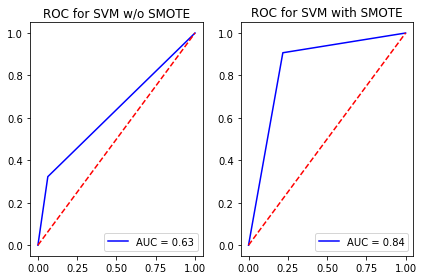

SVM Without SMOTE: 
('Accuracy ', 86.49)
             precision    recall  f1-score   support

          0       0.91      0.94      0.92      1698
          1       0.41      0.32      0.36       226

avg / total       0.85      0.86      0.86      1924

SVM With SMOTE: 
('Accuracy ', 84.34)
             precision    recall  f1-score   support

          0       0.90      0.78      0.83      1712
          1       0.80      0.91      0.85      1666

avg / total       0.85      0.84      0.84      3378



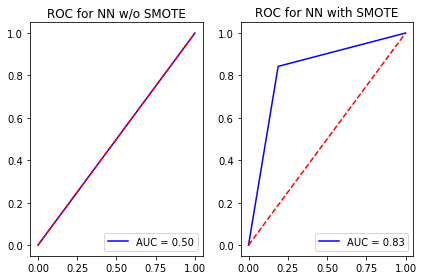

NN Without SMOTE: 
('Accuracy ', 88.25)
             precision    recall  f1-score   support

          0       0.88      1.00      0.94      1698
          1       0.00      0.00      0.00       226

avg / total       0.78      0.88      0.83      1924

NN With SMOTE: 
('Accuracy ', 82.68)
             precision    recall  f1-score   support

          0       0.84      0.81      0.83      1712
          1       0.81      0.84      0.83      1666

avg / total       0.83      0.83      0.83      3378



In [31]:
plotROC('nrer.csv','ECFP6')

('Assay: ', 'nrer.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


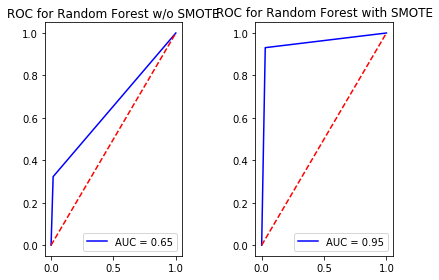

Random forest Without SMOTE: 
('Accuracy ', 90.59)
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      1698
          1       0.72      0.32      0.45       226

avg / total       0.89      0.91      0.89      1924

Random forest With SMOTE: 
('Accuracy ', 95.14)
             precision    recall  f1-score   support

          0       0.94      0.97      0.95      1712
          1       0.97      0.93      0.95      1665

avg / total       0.95      0.95      0.95      3377



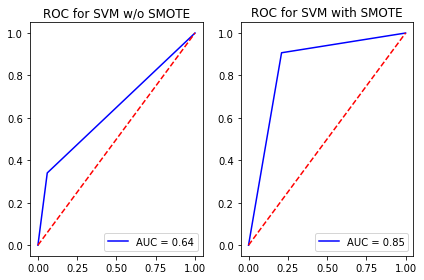

SVM Without SMOTE: 
('Accuracy ', 87.01)
             precision    recall  f1-score   support

          0       0.91      0.94      0.93      1698
          1       0.43      0.34      0.38       226

avg / total       0.86      0.87      0.86      1924

SVM With SMOTE: 
('Accuracy ', 84.75)
             precision    recall  f1-score   support

          0       0.90      0.79      0.84      1712
          1       0.81      0.91      0.85      1665

avg / total       0.85      0.85      0.85      3377



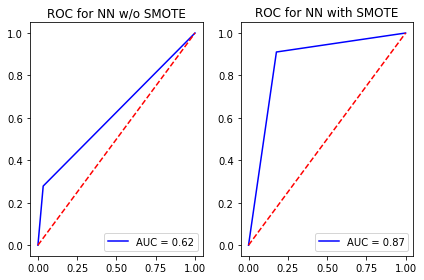

NN Without SMOTE: 
('Accuracy ', 88.57)
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      1698
          1       0.53      0.28      0.36       226

avg / total       0.86      0.89      0.87      1924

NN With SMOTE: 
('Accuracy ', 86.59)
             precision    recall  f1-score   support

          0       0.90      0.82      0.86      1712
          1       0.83      0.91      0.87      1665

avg / total       0.87      0.87      0.87      3377



In [9]:
plotROC('nrer.csv','ECFP4')

('Assay: ', 'nrerlbd.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


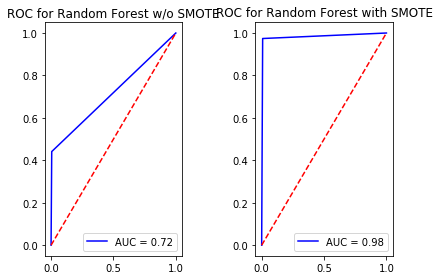

Random forest Without SMOTE: 
('Accuracy ', 96.89)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2085
          1       0.80      0.44      0.57       102

avg / total       0.97      0.97      0.96      2187

Random forest With SMOTE: 
('Accuracy ', 98.29)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2031
          1       0.99      0.97      0.98      2120

avg / total       0.98      0.98      0.98      4151



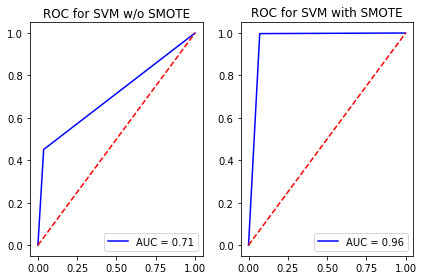

SVM Without SMOTE: 
('Accuracy ', 93.96)
             precision    recall  f1-score   support

          0       0.97      0.96      0.97      2085
          1       0.38      0.45      0.41       102

avg / total       0.95      0.94      0.94      2187

SVM With SMOTE: 
('Accuracy ', 96.36)
             precision    recall  f1-score   support

          0       1.00      0.93      0.96      2031
          1       0.94      1.00      0.97      2120

avg / total       0.97      0.96      0.96      4151



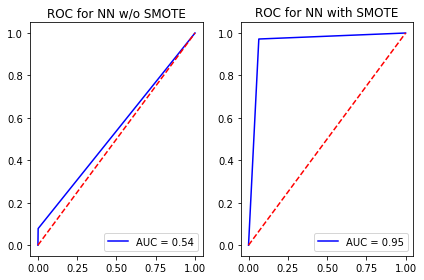

NN Without SMOTE: 
('Accuracy ', 95.56)
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      2085
          1       0.73      0.08      0.14       102

avg / total       0.95      0.96      0.94      2187

NN With SMOTE: 
('Accuracy ', 95.35)
             precision    recall  f1-score   support

          0       0.97      0.93      0.95      2031
          1       0.94      0.97      0.96      2120

avg / total       0.95      0.95      0.95      4151



In [32]:
plotROC('nrerlbd.csv','ECFP6')

('Assay: ', 'nrerlbd.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


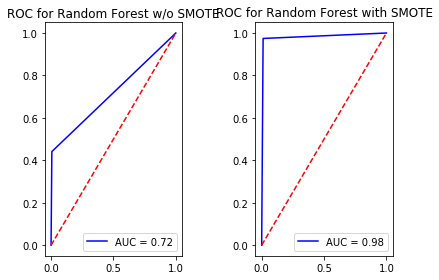

Random forest Without SMOTE: 
('Accuracy ', 96.8)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2085
          1       0.78      0.44      0.56       102

avg / total       0.96      0.97      0.96      2187

Random forest With SMOTE: 
('Accuracy ', 98.15)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2086
          1       0.99      0.97      0.98      2065

avg / total       0.98      0.98      0.98      4151



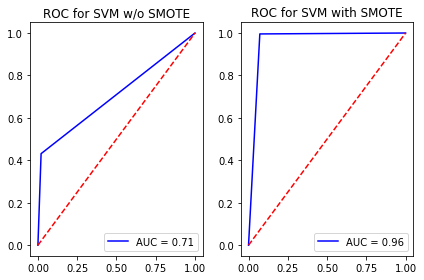

SVM Without SMOTE: 
('Accuracy ', 95.43)
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2085
          1       0.51      0.43      0.47       102

avg / total       0.95      0.95      0.95      2187

SVM With SMOTE: 
('Accuracy ', 96.17)
             precision    recall  f1-score   support

          0       1.00      0.93      0.96      2086
          1       0.93      1.00      0.96      2065

avg / total       0.96      0.96      0.96      4151



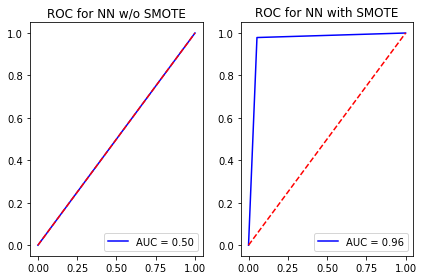

NN Without SMOTE: 
('Accuracy ', 95.34)
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      2085
          1       0.00      0.00      0.00       102

avg / total       0.91      0.95      0.93      2187

NN With SMOTE: 
('Accuracy ', 96.24)
             precision    recall  f1-score   support

          0       0.98      0.95      0.96      2086
          1       0.95      0.98      0.96      2065

avg / total       0.96      0.96      0.96      4151



In [10]:
plotROC('nrerlbd.csv','ECFP4')

('Assay: ', 'nrppargamma.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


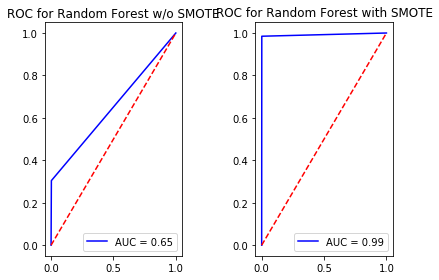

Random forest Without SMOTE: 
('Accuracy ', 98.19)
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1999
          1       0.74      0.30      0.43        46

avg / total       0.98      0.98      0.98      2045

Random forest With SMOTE: 
('Accuracy ', 99.2)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2002
          1       1.00      0.98      0.99      1977

avg / total       0.99      0.99      0.99      3979



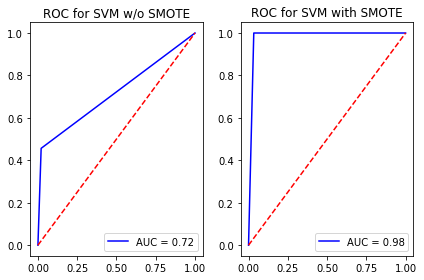

SVM Without SMOTE: 
('Accuracy ', 96.77)
             precision    recall  f1-score   support

          0       0.99      0.98      0.98      1999
          1       0.34      0.46      0.39        46

avg / total       0.97      0.97      0.97      2045

SVM With SMOTE: 
('Accuracy ', 98.32)
             precision    recall  f1-score   support

          0       1.00      0.97      0.98      2002
          1       0.97      1.00      0.98      1977

avg / total       0.98      0.98      0.98      3979



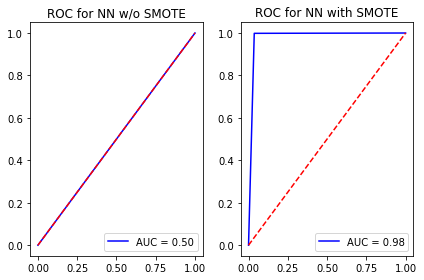

NN Without SMOTE: 
('Accuracy ', 97.75)
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1999
          1       0.00      0.00      0.00        46

avg / total       0.96      0.98      0.97      2045

NN With SMOTE: 
('Accuracy ', 98.09)
             precision    recall  f1-score   support

          0       1.00      0.96      0.98      2002
          1       0.96      1.00      0.98      1977

avg / total       0.98      0.98      0.98      3979



In [33]:
plotROC('nrppargamma.csv','ECFP6')

('Assay: ', 'nrppargamma.csv')


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


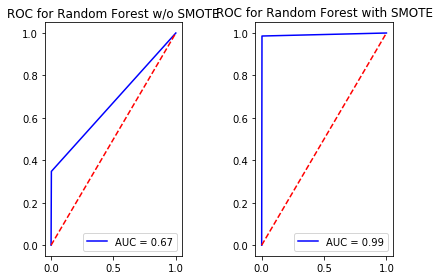

Random forest Without SMOTE: 
('Accuracy ', 98.29)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1999
          1       0.76      0.35      0.48        46

avg / total       0.98      0.98      0.98      2045

Random forest With SMOTE: 
('Accuracy ', 99.17)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2002
          1       1.00      0.99      0.99      1977

avg / total       0.99      0.99      0.99      3979



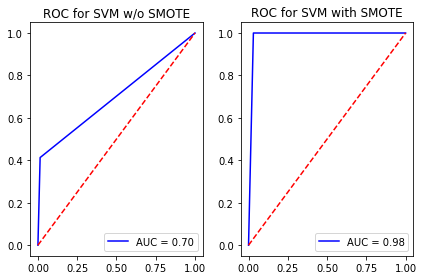

SVM Without SMOTE: 
('Accuracy ', 97.31)
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1999
          1       0.40      0.41      0.41        46

avg / total       0.97      0.97      0.97      2045

SVM With SMOTE: 
('Accuracy ', 98.44)
             precision    recall  f1-score   support

          0       1.00      0.97      0.98      2002
          1       0.97      1.00      0.98      1977

avg / total       0.98      0.98      0.98      3979



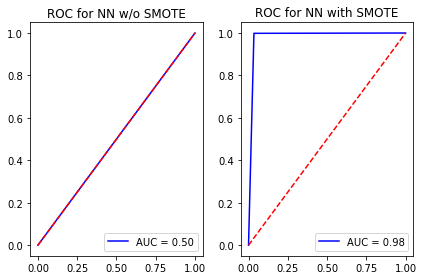

NN Without SMOTE: 
('Accuracy ', 97.75)
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1999
          1       0.00      0.00      0.00        46

avg / total       0.96      0.98      0.97      2045

NN With SMOTE: 
('Accuracy ', 98.19)
             precision    recall  f1-score   support

          0       1.00      0.97      0.98      2002
          1       0.97      1.00      0.98      1977

avg / total       0.98      0.98      0.98      3979



In [11]:
plotROC('nrppargamma.csv','ECFP4')

In [17]:
def calculateAccuracy(model,name,features,labels):
    kf = KFold(n_splits=5,shuffle=True)
    accuracy = []
    for train_index, test_index in kf.split(features,labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        if name == 'Neural Network':
            model.fit(X_train, y_train,epochs=100,batch_size=32,verbose=False)
            predictions = model.predict(X_test)
            accuracy.append(accuracyForNN(predictions,y_test))
        else:
            model.fit(X_train,y_train)
            accuracy.append(accuracy_score(y_test,model.predict(X_test)))

    print 'Accuracy for',name,'without smoting is',round(np.mean(accuracy)*100,2)
    
    kf = KFold(n_splits=5,shuffle=True)
    sm = SMOTETomek()
    features,labels = sm.fit_sample(features,labels)
    accuracy = []
    for train_index, test_index in kf.split(features,labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        if name == 'Neural Network':
            model.fit(X_train, y_train,epochs=100,batch_size=32,verbose=False)
            predictions = model.predict(X_test)
            accuracy.append(accuracyForNN(predictions,y_test))
        else:
            model.fit(X_train,y_train)
            accuracy.append(accuracy_score(y_test,model.predict(X_test)))

    print 'Accuracy for',name,'with smoting is',round(np.mean(accuracy)*100,2)
    
assays = ['nrahr.csv','nrar.csv','nrarlbd.csv','nraromatase.csv','nrer.csv','nrerlbd.csv','nrppargamma.csv']
print '5 fold cross-validation results'
for assay in assays:
    print 'For the assay',assay
    
    print 'using ECFP4 features'
    features,labels = preProcess(assay,'ECFP4')
    calculateAccuracy(svm.SVC(kernel='linear'),'linear SVM',features,labels)
    calculateAccuracy(RandomForestClassifier(n_estimators=25),'Random forest',features,labels)
    calculateAccuracy(defineNN(),'Neural Network',features,labels)
    
    print 'using ECFP6 features'
    features,labels = preProcess(assay,'ECFP6')
    calculateAccuracy(svm.SVC(kernel='linear'),'linear SVM',features,labels)
    calculateAccuracy(RandomForestClassifier(n_estimators=25),'Random forest',features,labels)
    calculateAccuracy(defineNN(),'Neural Network',features,labels)
    

5 fold cross-validation results
For the assay nrahr.csv
using ECFP4 features
Accuracy for linear SVM without smoting is 90.07
Accuracy for linear SVM with smoting is 92.96


/home/varshaneya/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Accuracy for Random forest without smoting is 92.65
Accuracy for Random forest with smoting is 96.51
Accuracy for Neural Network without smoting is 9429.2
Accuracy for Neural Network with smoting is 9606.6
using ECFP6 features
Accuracy for linear SVM without smoting is 89.67
Accuracy for linear SVM with smoting is 92.46
Accuracy for Random forest without smoting is 92.59
Accuracy for Random forest with smoting is 96.43
Accuracy for Neural Network without smoting is 9284.6
Accuracy for Neural Network with smoting is 9471.4
For the assay nrar.csv
using ECFP4 features
Accuracy for linear SVM without smoting is 96.83
Accuracy for linear SVM with smoting is 96.99
Accuracy for Random forest without smoting is 97.71
Accuracy for Random forest with smoting is 98.75
Accuracy for Neural Network without smoting is 9780.8
Accuracy for Neural Network with smoting is 9794.6
using ECFP6 features
Accuracy for linear SVM without smoting is 96.36
Accuracy for linear SVM with smoting is 97.27
Accuracy fo

KeyboardInterrupt: 

In [19]:
print 'using ECFP6 features','nrar.csv'
features,labels = preProcess('nrar.csv','ECFP6')
calculateAccuracy(defineNN(),'Neural Network',features,labels)

assays = ['nrarlbd.csv','nraromatase.csv','nrer.csv','nrerlbd.csv','nrppargamma.csv']
print '5 fold cross-validation results'
for assay in assays:
    print 'For the assay',assay
    
    print 'using ECFP4 features'
    features,labels = preProcess(assay,'ECFP4')
    #calculateAccuracy(svm.SVC(kernel='linear'),'linear SVM',features,labels)
    #calculateAccuracy(RandomForestClassifier(n_estimators=25),'Random forest',features,labels)
    calculateAccuracy(defineNN(),'Neural Network',features,labels)
    
    print 'using ECFP6 features'
    features,labels = preProcess(assay,'ECFP6')
    #calculateAccuracy(svm.SVC(kernel='linear'),'linear SVM',features,labels)
    #calculateAccuracy(RandomForestClassifier(n_estimators=25),'Random forest',features,labels)
    calculateAccuracy(defineNN(),'Neural Network',features,labels)

using ECFP6 features nrar.csv
Accuracy for Neural Network without smoting is 96.0
Accuracy for Neural Network with smoting is 50.0
5 fold cross-validation results
For the assay nrarlbd.csv
using ECFP4 features
Accuracy for Neural Network without smoting is 96.6
Accuracy for Neural Network with smoting is 50.0
using ECFP6 features
Accuracy for Neural Network without smoting is 98.0
Accuracy for Neural Network with smoting is 99.0
For the assay nraromatase.csv
using ECFP4 features
Accuracy for Neural Network without smoting is 94.8
Accuracy for Neural Network with smoting is 50.2
using ECFP6 features
Accuracy for Neural Network without smoting is 95.8
Accuracy for Neural Network with smoting is 97.4
For the assay nrer.csv
using ECFP4 features
Accuracy for Neural Network without smoting is 91.2
Accuracy for Neural Network with smoting is 86.8
using ECFP6 features
Accuracy for Neural Network without smoting is 89.8
Accuracy for Neural Network with smoting is 89.8
For the assay nrerlbd.csv
